In [1]:
### Plot the distribution of NR remap peaks on a genomic meta exon by nb of remap overlap in exons

## Packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib
from pathlib import Path
import collections
from scipy.interpolate import interp1d
matplotlib.rcParams['pdf.fonttype'] = 42

## Functions
def summit_distribution(file, species):
    result = {}
    with open(file) as f:
        for line in f:
            strand = line.strip().split()[5]
            exon_start = line.strip().split()[1]
            exon_end = line.strip().split()[2]
            peak = line.strip().split()[8]

            size_exon = int(exon_end) - int(exon_start)
            middle_exon = int(exon_start) + round(size_exon/2)

            if strand == "-": #we need to reverse the neg strand results based on the exon
                # peak behind exon
                if int(peak) < middle_exon:
                    perc_place = middle_exon - int(peak) #reversed 

                    if perc_place not in result:
                        result[perc_place] = 1
                    else:
                        result[perc_place] += 1

                # peak in front of exon
                elif int(peak) >= middle_exon:
                    place_peak = int(peak) - middle_exon

                    perc_place = 0-place_peak #reversed


                    if perc_place not in result:
                        result[perc_place] = 1
                    else:
                        result[perc_place] += 1

            #strand + is no change            
            else:
                # peak behind exon
                if int(peak) < middle_exon:
                    place_peak = middle_exon - int(peak)
                    perc_place = 0-place_peak

                    if perc_place not in result:
                        result[perc_place] = 1
                    else:
                        result[perc_place] += 1

                # peak in front of exon
                elif int(peak) >= middle_exon:
                    perc_place = int(peak) - middle_exon

                    if perc_place not in result:
                        result[perc_place] = 1
                    else:
                        result[perc_place] += 1
    
    # Filter extremes result (on the sides) for better plotting
    result_filtered = {}
    if species == "hg" or species == "mm":
        cutoff = -1000
    else:
        cutoff = -400 #dm and atha

    for key,item in result.items():
        if key < cutoff or key > abs(cutoff):  
            continue
        else:
            result_filtered[key]=item
    
    return result_filtered

In [2]:
### Compute distribution
hg5 = summit_distribution("/home/mouren/Data/final_files_tokeep/other_species/files_remap_distrib/hg5", "hg") 
hg510 = summit_distribution("/home/mouren/Data/final_files_tokeep/other_species/files_remap_distrib/hg5_10", "hg") 
hg10 = summit_distribution("/home/mouren/Data/final_files_tokeep/other_species/files_remap_distrib/hg10", "hg") 

In [4]:
### Normalize by total of exons
hg5_norm = {}
hg510_norm = {}
hg10_norm = {}

cpt = len({line.split('\t')[3] for line in open("/home/mouren/Data/final_files_tokeep/other_species/files_remap_distrib/hg5")})
for key,value in hg5.items():
    hg5_norm[key] = value/cpt
cpt = len({line.split('\t')[3] for line in open("/home/mouren/Data/final_files_tokeep/other_species/files_remap_distrib/hg5_10")})
for key, value in hg510.items():
    hg510_norm[key] = value/cpt
cpt = len({line.split('\t')[3] for line in open("/home/mouren/Data/final_files_tokeep/other_species/files_remap_distrib/hg10")})
for key, value in hg10.items():
    hg10_norm[key] = value/cpt

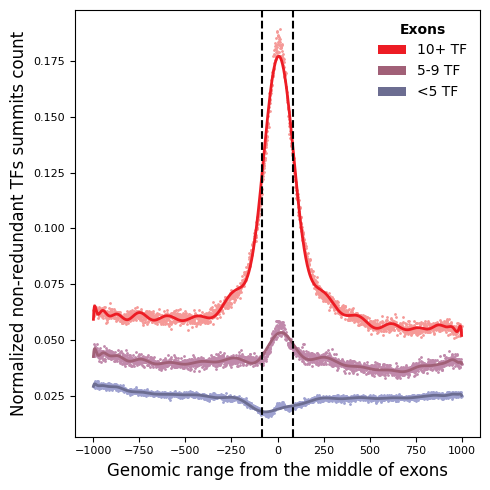

In [ ]:

x_analysis5 = list(hg5_norm.keys())
y_analysis5 = list(hg5_norm.values())
if len(x_analysis5) > 30:  # ensure enough points to fit
    model_analysis5 = np.poly1d(np.polyfit(x_analysis5, y_analysis5, 30))
else:
    # fallback: lower-order fit or direct connect
    model_analysis5 = None

# 2) 5_10
x_analysis510 = list(hg510_norm.keys())
y_analysis510 = list(hg510_norm.values())
if len(x_analysis510) > 30:  # ensure enough points to fit
    model_analysis510 = np.poly1d(np.polyfit(x_analysis510, y_analysis510, 30))
else:
    # fallback: lower-order fit or direct connect
    model_analysis510 = None

# 3) 10
x_analysis10 = list(hg10_norm.keys())
y_analysis10 = list(hg10_norm.values())
if len(x_analysis10) > 30:  # ensure enough points to fit
    model_analysis10 = np.poly1d(np.polyfit(x_analysis10, y_analysis10, 30))
else:
    # fallback: lower-order fit or direct connect
    model_analysis10 = None

## Scatter raw points
cutoff = 1000

plt.figure(figsize=(5,5))

plt.scatter(x_analysis5, y_analysis5, color="#9fa2d1", s=1, label='<5 TF')
if model_analysis5:
    myline = np.linspace(min(x_analysis5), max(x_analysis5), cutoff) #1000 for hsap and mm; 400 for dm and tair
    plt.plot(myline, model_analysis5(myline), color="#6c6d91", label='<5 TF', linewidth=2)

plt.scatter(x_analysis510, y_analysis510, color="#c089ab", s=1, label='5-9 TF')
if model_analysis510:
    myline = np.linspace(min(x_analysis510), max(x_analysis510), cutoff) #1000 for hsap and mm; 400 for dm and tair
    plt.plot(myline, model_analysis510(myline), color="#a16077", label='5-9 TF', linewidth=2)

plt.scatter(x_analysis10, y_analysis10, color="#f59997", s=1, label='10+ TF')
if model_analysis10:
    myline = np.linspace(min(x_analysis10), max(x_analysis10), cutoff) #1000 for hsap and mm; 400 for dm and tair
    plt.plot(myline, model_analysis10(myline), color="#ed1c24", label='10+ TF', linewidth=2)

mean_exon_size = -82

plt.axvline(x=abs(mean_exon_size),  color='k', linestyle='--', label='Mean size boundary')
plt.axvline(x=mean_exon_size, color='k', linestyle='--')

#################################
# 4. CREATE THE PLOT
#################################

plt.tick_params(axis='y', labelsize=8)  # Use labelsize=8 (or another number) to reduce font size
plt.tick_params(axis='x', labelsize=8)

###  Legend and axis title
## Legend
from matplotlib.patches import Patch
from matplotlib import font_manager

c1 = Patch(facecolor='#ed1c24', label="10+ TF")
c2 = Patch(facecolor='#a16077', label="5-9 TF")
c3 = Patch(facecolor='#6c6d91', label="<5 TF")

plt.legend(
    handles=[c1, c2, c3],
    loc='upper right', title="Exons",
    title_fontproperties=font_manager.FontProperties(weight='bold'),  # Make title bold
    ncol=1,
    fontsize=10,
    frameon=False
)

## Axes
plt.ylabel("Normalized non-redundant TFs summits count",fontsize=12)
plt.xlabel("Genomic range from the middle of exons",fontsize=12)

plt.tight_layout()

plt.savefig("/home/mouren/Images/tls1/main_figures/fig1/distrib_remap_exons_by_nb_ovlp_hsap.pdf", format="pdf", bbox_inches="tight", dpi=450)

plt.show()
